In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
from models.recurrent_models_pyramid import LSTMGenerator, LSTMDiscriminator
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

/home/dxlab/jupyter/envs/gpu_taeyoung_py36/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=20
    lr=0.0002
    cuda = True
    manualSeed=2
    
opt_trn=ArgsTrn()

In [3]:
torch.manual_seed(opt_trn.manualSeed)
cudnn.benchmark = True

In [4]:
X_train = np.load('./X_train.npy')
y_train = np.load('./y_train.npy')

In [5]:
X_test = np.load('./X_test.npy')
y_test = np.load('./y_test.npy')

In [6]:
X_train = X_train[:, :60]

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)
dataset = TensorDataset(X_train, y_train)

torch.Size([11000, 60, 1])
torch.Size([11000])


In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

In [9]:
device = torch.device("cuda:0" if opt_trn.cuda else "cpu") # select the device
seq_len = 60
in_dim = 1

In [10]:
# Create generator and discriminator models
netD = LSTMDiscriminator(in_dim=in_dim, device=device).to(device)
netG = LSTMGenerator(in_dim=in_dim, out_dim=in_dim, device=device).to(device)

In [11]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm0): LSTM(1, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [12]:
# Setup loss function
criterion = nn.BCELoss().to(device)

In [13]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt_trn.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt_trn.lr)

In [14]:
real_label = 1
fake_label = 0

for epoch in range(opt_trn.epochs):
    for i, (x,y) in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output,_ = netD.forward(real)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake,_ = netG.forward(noise)
        output,_ = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake,_ = netG.forward(noise)
        label.fill_(real_label) 
        output,_ = netD.forward(fake)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()
        
        

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
          % (epoch, opt_trn.epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    print()

/home/dxlab/jupyter/envs/gpu_taeyoung_py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/dxlab/jupyter/envs/gpu_taeyoung_py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


[0/20][343/344] Loss_D: 1.3779 Loss_G: 0.6405 D(x): 0.5360 D(G(z)): 0.5286 / 0.5278
[1/20][343/344] Loss_D: 1.2641 Loss_G: 0.5501 D(x): 0.6719 D(G(z)): 0.5777 / 0.5774
[2/20][343/344] Loss_D: 0.8388 Loss_G: 1.6729 D(x): 0.5945 D(G(z)): 0.2372 / 0.2366
[3/20][343/344] Loss_D: 1.5179 Loss_G: 0.3859 D(x): 0.6909 D(G(z)): 0.6810 / 0.6807
[4/20][343/344] Loss_D: 1.4769 Loss_G: 0.4348 D(x): 0.6492 D(G(z)): 0.6477 / 0.6477
[5/20][343/344] Loss_D: 1.4995 Loss_G: 0.4166 D(x): 0.6574 D(G(z)): 0.6597 / 0.6596
[6/20][343/344] Loss_D: 1.4809 Loss_G: 0.4266 D(x): 0.6568 D(G(z)): 0.6531 / 0.6530
[7/20][343/344] Loss_D: 1.5032 Loss_G: 0.4078 D(x): 0.6665 D(G(z)): 0.6656 / 0.6655
[8/20][343/344] Loss_D: 1.4970 Loss_G: 0.4165 D(x): 0.6588 D(G(z)): 0.6597 / 0.6596
[9/20][343/344] Loss_D: 1.5033 Loss_G: 0.4080 D(x): 0.6659 D(G(z)): 0.6654 / 0.6652
[10/20][343/344] Loss_D: 1.4925 Loss_G: 0.4190 D(x): 0.6585 D(G(z)): 0.6581 / 0.6579
[11/20][343/344] Loss_D: 1.4970 Loss_G: 0.4151 D(x): 0.6604 D(G(z)): 0.6607

In [15]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest() 

In [16]:
generator = netG # changing reference variable 
discriminator = netD # changing reference variable 

In [17]:
X_test = np.load('./X_test.npy')
y_test = np.load('./y_test.npy')

In [18]:
X_test = X_test[:, :60]

In [19]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
print(y_test.shape)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([11000, 60, 1])
torch.Size([11000])


In [20]:
print(y_test)

tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [21]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

In [22]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

In [29]:
loss_list = []
#y_list = []

batch_size = 32
window_length = 60
n_feature = 1

for i, (x,y) in enumerate(test_dataloader):
    print(i, y)
    
    #z = Variable(init.normal(torch.zeros(opt_test.batch_size,
    #                                 test_dataset.window_length, 
    #                                 test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    
    z = Variable(init.normal(torch.zeros(batch_size,
                                     window_length, 
                                     n_feature),mean=0,std=0.1),requires_grad=True) 
    
    z_optimizer = torch.optim.Adam([z],lr=1e-2)
    
    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = generator(z.cuda())
        loss = Anomaly_score(Variable(x).cuda(), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break


0 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


/home/dxlab/jupyter/envs/gpu_taeyoung_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


~~~~~~~~loss=136.6690673828125,  y=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) ~~~~~~~~~~
1 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
~~~~~~~~loss=133.79026794433594,  y=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) ~~~~~~~~~~
2 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
~~~~~~~~loss=131.47897338867188,  y=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) ~~~~~~~~~~
3 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

KeyboardInterrupt: 

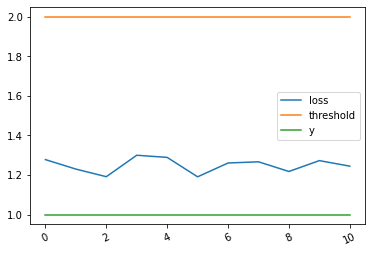

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 2.0 # Anomaly score threshold for an instance to be considered as anomaly 

#TIME_STEPS = dataset.window_length
#test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df = pd.DataFrame(index=range(len(loss_list)))
#test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
test_score_df['loss'] = [loss.item()/window_length for loss in loss_list]
test_score_df['y'] = test_dataset.tensors[1][:len(loss_list)]
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.tensors[0][:len(loss_list)]]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

In [ ]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

In [ ]:
loss_list = []
#y_list = []

batch_size = 32
window_length = 60
n_feature = 1

for i, (x,y) in enumerate(dataloader):
    print(i, y)
    
    #z = Variable(init.normal(torch.zeros(opt_test.batch_size,
    #                                 test_dataset.window_length, 
    #                                 test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    
    z = Variable(init.normal(torch.zeros(batch_size,
                                     window_length, 
                                     n_feature),mean=0,std=0.1),requires_grad=True) 
    
    z_optimizer = torch.optim.Adam([z],lr=1e-2)
    
    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = generator(z.cuda())
        loss = Anomaly_score(Variable(x).cuda(), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 3.0 # Anomaly score threshold for an instance to be considered as anomaly 

#TIME_STEPS = dataset.window_length
#test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df = pd.DataFrame(index=range(len(loss_list)))
#test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
test_score_df['loss'] = [loss.item()/window_length for loss in loss_list]
test_score_df['y'] = dataset.tensors[1][:len(loss_list)]
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in dataset.tensors[0][:len(loss_list)]]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();